Build CNN:
- import libraries
- Load and normalize data
- OHEC data
- Split data into training and test
- Build CNN class with layers
- Evaluate model
- Tune hyper params
- Improve model and see what can be done better


The basic steps to build an image classification model using a neural network are:

- Flatten the input image dimensions to 1D (width pixels x height pixels)
- Normalize the image pixel values (divide by 255)
- One-Hot Encode the categorical column
- Build a model architecture (Sequential) with Dense layers
- Train the model and make predictions

In [ ]:
import pickle as pkl
import numpy as np
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class ConfigureDataset(Dataset):
    def __init__(self, X_Train, Y_Train, transform=None):
        self.X_Train = X_Train
        self.Y_Train = Y_Train
        self.transform = transform

    def __len__(self):
        return len(self.X_Train)

    def __getitem__(self, idx):
        x = self.X_Train[idx]
        y = self.Y_Train[idx]

        if self.transform:
            x = self.transform(x)

        return x, y

In [ ]:
# converts labels from an array of 36 to a value between 0 nd 259
def convert_label(label):
    numl = label[:10]
    letter = label[10:]
    return 26 * np.where(numl == 1)[0][0] + np.where(letter == 1)[0][0]


In [ ]:
file = open('.../data/images_l.pkl', 'rb')
X_data = pkl.load(file)
file.close()

file = open('.../data/labels_l.pkl', 'rb')
Y_data = pkl.load(file)
file.close()

Y_data_2 = []
print(Y_data[:10])
for idx in range(len(Y_data)):
    Y_data_2.append(convert_label(Y_data[idx]))
print(Y_data_2[:10])

X_train = X_data[:25000]
Y_train = Y_data_2[:25000]

X_test = X_data[25000:]
Y_test = Y_data_2[25000:]

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0.

In [ ]:
print(type(X_train[0][0][0]))

<class 'numpy.float64'>


In [ ]:
train_set = ConfigureDataset(X_train, Y_train, transform=transforms.Compose([transforms.ToTensor(),transforms.RandomHorizontalFlip(), transforms.Normalize(12.2904, 48.2189)]))
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

In [ ]:
test_set = ConfigureDataset(X_test, Y_test, transform=transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip(), transforms.Normalize(12.2904, 48.2189)]))
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

In [ ]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1

    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [ ]:
print(next(iter(train_loader))[0][0].mean())

tensor(-0.0381, dtype=torch.float64)


In [ ]:
print(get_mean_and_std(train_loader))
print(get_mean_and_std(test_loader))

(tensor([1.4850e-05], dtype=torch.float64), tensor([1.0000], dtype=torch.float64))
(tensor([0.0005], dtype=torch.float64), tensor([1.0017], dtype=torch.float64))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


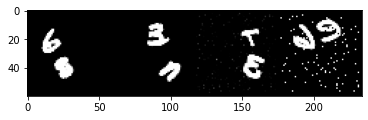

IndexError: ignored

In [ ]:
import matplotlib.pyplot as plt
import torchvision
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# print(images)
# print(labels)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % convert_label(labels[j]) for j in range(8)))

In [ ]:
# Define a convolutional neural network

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(1, 128, 5),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(128, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(256, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.full_layer_1 = nn.Sequential(
            nn.Linear(256 * 5 * 5, 1024),
            nn.ReLU()
        )

        self.output_layer = nn.Sequential(
            nn.Linear(1024, 260),
        )

    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = x.view(-1, 256 * 5 * 5)
        x = self.full_layer_1(x)
        x = self.output_layer(x)

        return x

net = Net().to(device)

In [ ]:
# Define a loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4, weight_decay=1e-5)#lr=0.01,momentum=0.9,lr=3e-4


In [ ]:
# test one set of images
# images and lables from image print cell
# zero the parameter gradients
optimizer.zero_grad()

images, labels = images.cuda(), labels.cuda()#when using gpu uncomment

# forward + backward + optimize
outputs = net(images.float())
loss = criterion(outputs, labels)
loss.backward()
optimizer.step()

_, predicted = torch.max(outputs.data, 1)


In [ ]:
print(loss)
print(labels)
print(predicted)
print((predicted == labels).sum().item())

tensor(5.5793, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor([127, 217, 211,  72,  14,  39, 200,  64,  46, 233,   2,  82, 152, 207,
         13, 128,   5, 126, 215,  81,  83,   6,  77,  92,  89, 197, 238, 105,
         83,  93, 255,  50, 204, 118,  48,  11,  86, 233, 124, 184, 197, 204,
        253, 135, 150,   7,  47, 146, 204, 107, 166, 167, 213, 221, 174, 198,
         52, 168, 226,  49, 220,   7, 216, 206], device='cuda:0')
tensor([106, 194, 206,  48,  48,  48,  48, 194, 173, 179,  51, 173,  48, 156,
         49,  48,  48, 173,  55,  48, 173, 173,  48,  48, 173,  48, 173, 173,
        173,  51,  48,  48, 173,  48, 194,  48, 194,  48, 173, 173,  48, 246,
        231,  48,  48,  49, 173, 173, 173,  48, 173, 173,  15, 173, 173, 194,
        156,  48, 248, 173, 179, 173, 173,  11], device='cuda:0')
0


In [ ]:
# Train the network

for epoch in range(20):  # loop over the dataset multiple times
    net = net.float()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        inputs, labels = inputs.cuda(), labels.cuda()#when using gpu uncomment

        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 5.553
[1,   100] loss: 4.949
[1,   150] loss: 4.429
[1,   200] loss: 4.134
[1,   250] loss: 4.015
[1,   300] loss: 3.920
[1,   350] loss: 3.846
[2,    50] loss: 3.702
[2,   100] loss: 3.670
[2,   150] loss: 3.552
[2,   200] loss: 3.528
[2,   250] loss: 3.451
[2,   300] loss: 3.357
[2,   350] loss: 3.279
[3,    50] loss: 3.170
[3,   100] loss: 3.112
[3,   150] loss: 3.054
[3,   200] loss: 2.978
[3,   250] loss: 2.928
[3,   300] loss: 2.892
[3,   350] loss: 2.815
[4,    50] loss: 2.605
[4,   100] loss: 2.578
[4,   150] loss: 2.476
[4,   200] loss: 2.447
[4,   250] loss: 2.380
[4,   300] loss: 2.328
[4,   350] loss: 2.336
[5,    50] loss: 2.142
[5,   100] loss: 2.062
[5,   150] loss: 2.039
[5,   200] loss: 1.997
[5,   250] loss: 1.982
[5,   300] loss: 1.950
[5,   350] loss: 1.934
[6,    50] loss: 1.740
[6,   100] loss: 1.683
[6,   150] loss: 1.705
[6,   200] loss: 1.621
[6,   250] loss: 1.667
[6,   300] loss: 1.644
[6,   350] loss: 1.579
[7,    50] loss: 1.468
[7,   100] 

In [ ]:
print(list(net.parameters()))


In [ ]:
testiter = iter(test_loader)
images, labels = next(testiter)

images, labels = images.cuda(), labels.cuda()#uncomment when using gpu

outputs = net(images.float())
print(outputs.data)
_, predicted = torch.max(outputs.data, 1)
print(predicted)
print(labels)

tensor([[-29.0355, -56.3075, -14.9616,  ..., -33.2334, -15.2489, -27.8930],
        [-19.8796, -44.1998, -22.8922,  ..., -21.3754,  -8.7808, -44.5773],
        [-18.5265, -40.8488, -46.1105,  ..., -12.4878, -20.9681, -23.5038],
        ...,
        [-19.9764, -21.9750, -36.7555,  ..., -30.3611, -32.4980, -16.7026],
        [-22.5621, -33.8767, -22.5670,  ..., -25.4388, -19.6531, -37.1469],
        [-40.3006, -20.4145, -42.1556,  ..., -41.4918, -49.7571, -32.4384]],
       device='cuda:0')
tensor([217, 180, 238, 190,  55,  67,  69, 204,  17, 189, 233, 250, 228,  17,
         76,  34, 164, 168,   5,  16, 122, 180,  76, 213, 113, 114,  17, 184,
        212, 113, 102, 212,  74, 240, 153, 238,  87,  45, 221, 246,  32,  77,
         78, 212,  12, 154,  67, 239, 170, 151, 133, 192, 160,   4,  60, 241,
         36,  82, 117, 184, 125, 172, 151, 167], device='cuda:0')
tensor([217, 228, 108, 190,  55, 233,  69, 204,  17, 189, 233, 250, 228,  17,
         46,  34, 164, 168,   5, 235, 122, 180, 12

In [ ]:
# Let's see how the network performs on the whole test dataset

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data

        images, labels = images.cuda(), labels.cuda() #uncomment when using gpu

        outputs = net(images.float())
        # _, predicted = torch.topk(outputs, 2)
        _, predicted = torch.max(outputs.data, 1)

        total += len(labels)
        correct += (predicted == labels).sum().item()


In [ ]:
print(outputs.shape)
print(labels.shape)
print(total)
print(correct)

print(torch.max(outputs.data, 1))
print(labels)

print('Accuracy of the network on the 5000 test images: %d %%' % (
    100 * correct / total))

torch.Size([8, 260])
torch.Size([8])
5000
3602
torch.return_types.max(
values=tensor([  4.2869, -10.1858,  -0.7809,  -3.6001,   4.8804,  -4.0561,  -6.6670,
         -0.4196], device='cuda:0'),
indices=tensor([174, 100,  49, 136,  49, 257, 107, 122], device='cuda:0'))
tensor([174, 100,  49, 135,  49, 257, 107, 122], device='cuda:0')
Accuracy of the network on the 5000 test images: 72 %
